In [34]:
import numpy as np
import scipy
import pylab
from matplotlib.pyplot import figure

import pylab
import matplotlib
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.opflow import X, Z, Y, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.circuit.library import TwoLocal, QAOAAnsatz

from qiskit.algorithms.optimizers import ADAM, CG, COBYLA, L_BFGS_B, GradientDescent, NELDER_MEAD, \
                                            NFT, POWELL, SLSQP, SPSA, TNC


#Imports Functions for Building Hamiltonains
%run Utils.ipynb
np.set_printoptions(formatter={'float': '{:0.3f}'.format})

In [35]:
def findEigen(x, N):
    N = int(N)
    m = 0
    target_coupling, mixer_coupling = makeSchwinger(N, 1, np.sqrt(x) / 2 * m, x/2.0)

    mixer_hamiltonian = mixer_coupling.getHamiltonian()
    target_hamiltonian = target_coupling.getHamiltonian()

    complete_hamiltonian = mixer_hamiltonian + target_hamiltonian

    matrix_ham = complete_hamiltonian.to_matrix()
    sparse_matrix_ham = scipy.sparse.bsr_matrix(matrix_ham)
    eigenvalues = np.sort(scipy.sparse.linalg.eigsh(sparse_matrix_ham, return_eigenvectors=False))
    
    w0, w1 = eigenvalues[:2]
    
    return w0/(2*N*x), (w1-w0)/(2*np.sqrt(x)) - 2*m

x_res = 500
x_min, x_max = 200, 2000
n_res = 3

x_val, qubits = np.meshgrid(np.linspace(x_min, x_max, x_res), np.linspace(4, 2+(n_res*2), n_res))
w0 = np.zeros([n_res, x_res], dtype=float)
w1 = np.zeros([n_res, x_res], dtype=float)

for i in range(n_res):
    for j in range(x_res):
        w0[i,j], w1[i,j] = findEigen(x_val[i,j], qubits[i,j])
        print(f'{((i * x_res) + j + 1) / (x_res * n_res) * 100 :3.2f}%   Qubit Count: {6 + i * 2}', end='\r', flush = True)
print('Done                          ')

Done                          


In [36]:
%matplotlib qt
matplotlib.rcParams['figure.figsize'] = (12, 8)
fig = plt.figure(1)
ax = plt.axes(projection='3d')

ax.plot_surface(x_val, qubits, w0, cmap='viridis',edgecolor='none', alpha = 0.7)
ax.plot_surface(x_val, qubits, np.full([n_res, x_res], -1/np.pi), cmap='viridis',edgecolor='none', alpha = .3)

ax.set_xlabel('X')
ax.set_ylabel('Qubits')
ax.set_zlabel('Ground State');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


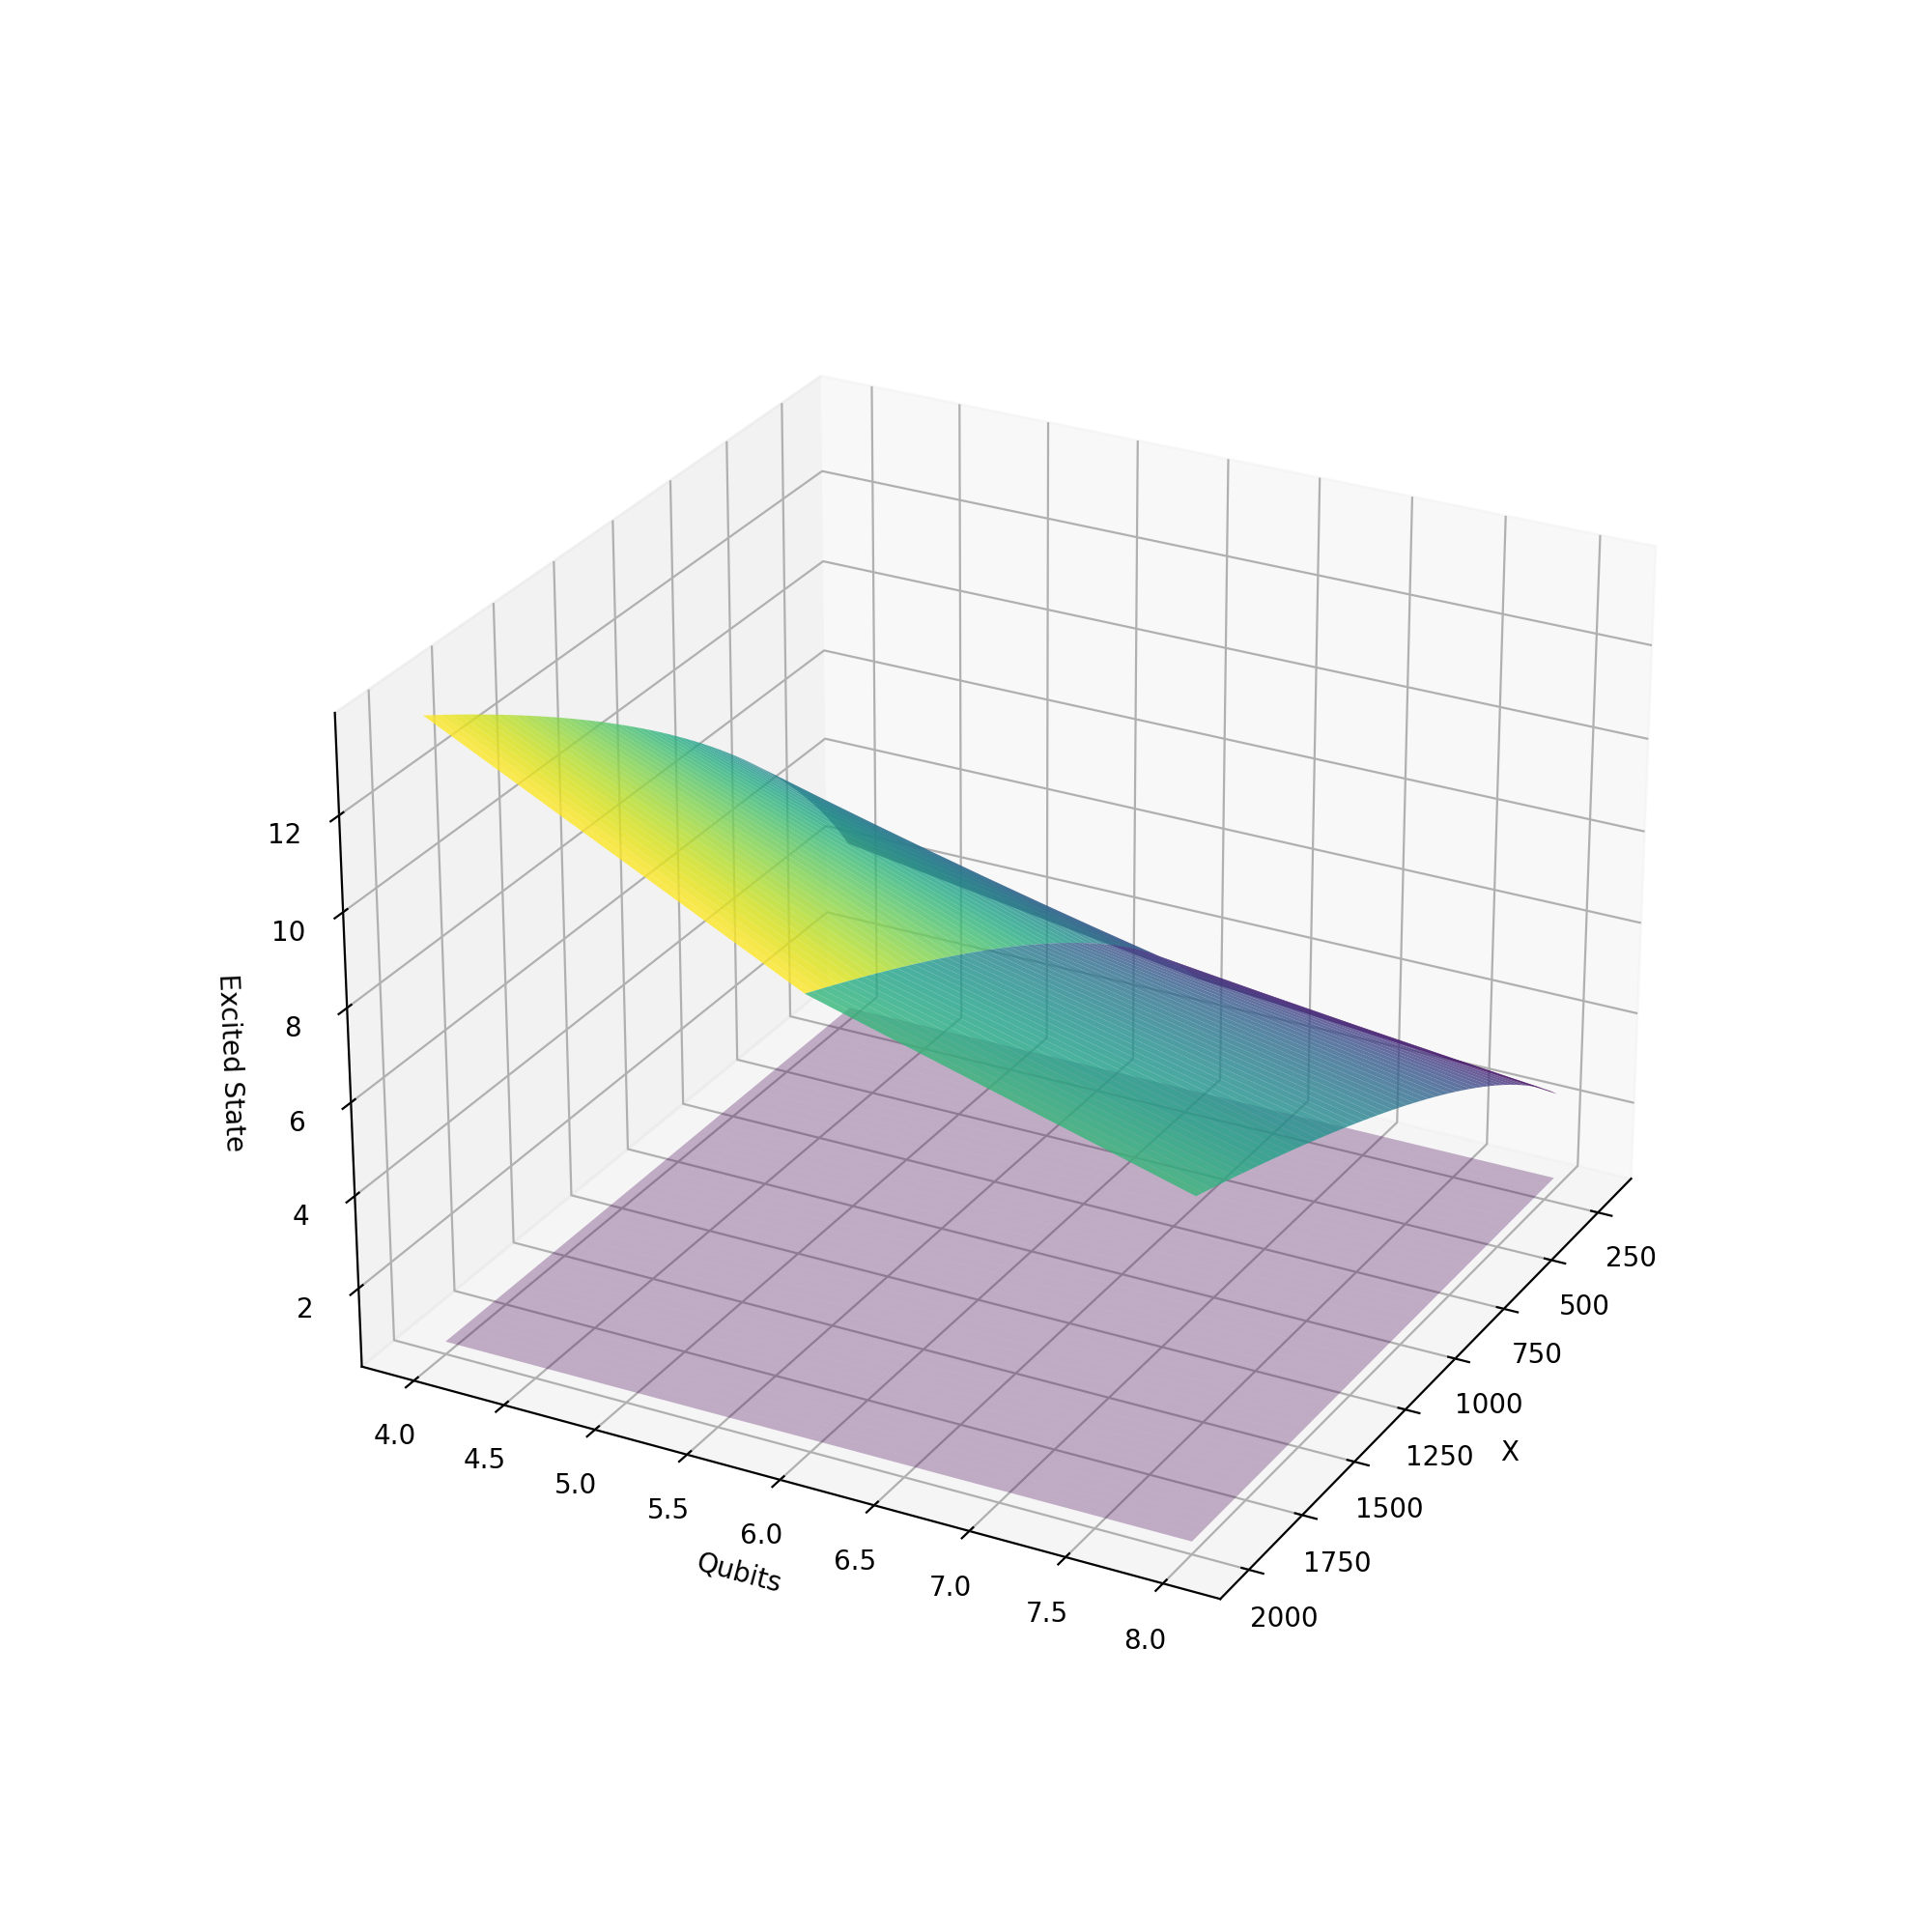

In [33]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure(1)
ax = plt.axes(projection='3d')

ax.plot_surface(x_val, qubits, w1, cmap='viridis',edgecolor='none', alpha = 0.8)
ax.plot_surface(x_val, qubits, np.full([n_res, x_res], 1/np.sqrt(np.pi)), cmap='viridis',edgecolor='none', alpha = .3)

ax.set_xlabel('X')
ax.set_ylabel('Qubits')
ax.set_zlabel('Excited State');

Text(0.5, 1.0, 'Energy convergence for various optimizers')

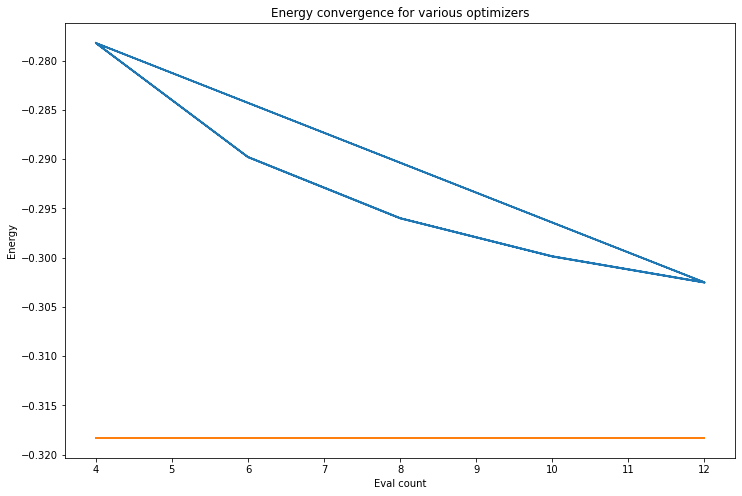

In [92]:
figure(dpi=120)
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(qubits, grnd)
pylab.plot(qubits, [-1/np.pi] * len(qubits))
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')



Text(0.5, 1.0, 'Energy convergence for various optimizers')

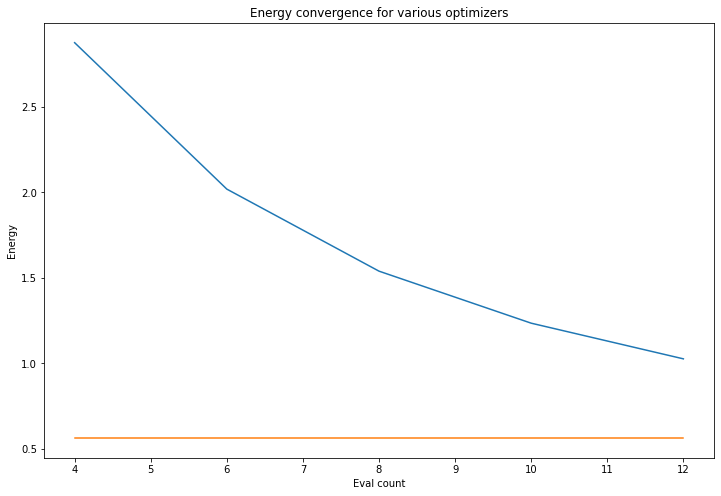

In [90]:
figure(dpi=120)
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(qubits, excited)
pylab.plot(qubits, [1/np.sqrt(np.pi)] * len(qubits))
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')

In [100]:
list(range(4,14,2))

[4, 6, 8, 10, 12]